# 6. Additional Images
Instead of using duplicates/augumented data, we downloaded additional images by web scrapping to deal with imbalance in the original dataset.

In [1]:
import pickle
import time
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import seaborn as sns
from random import seed, randint

from utils import destination

In [2]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)

# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
Y = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
Y_df = pd.DataFrame(Y.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, Y_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = Y_df.shape[1]


## Imbalanced Dataset
Original dataset contains many images with hashtags `love`, `frined`, `beach`, etc., which results in model being biased in favor of those hashtags.

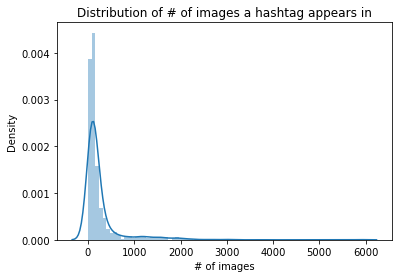

love                5892
friend              3646
beach               3025
family              2966
yellow              2667
                    ... 
wake                   5
shamelessselefie       5
wakingup               4
hters                  4
daytime                2
Length: 997, dtype: int64

In [6]:
tag_counts = Y_df.sum(axis=0).sort_values(ascending=True)

plt.title("Distribution of # of images a hashtag appears in")
sns.distplot(tag_counts, bins=75, axlabel="# of images")
plt.show()
tag_counts.sort_values(ascending=False)

## Images to Add

To fix this problem, we download images with minoriy hashtags by web scrapping. Notice that images are usually labeled with multiple hashtags. So, we download images that are associated with several minority hashtags. 

To decide which hashtags to be combined, we use `sim_tag` dictionary we create in `3-improve-hashtag.ipynb`. For example, suppose `beach`, `ocean`, and `river` are minoriy hashtags. Then, to add images associated wiht `beach`, we first create a query by concatenating all the hashtags in `sim_tag["beach"]`. Now let's say `sim_tag["beach"] = ["ocean", "river"]`. Then, our query for `beach` becomes `beach ocean river` and we use this query to look up images.

To decide how many images to download, we use the following formula:
$$
\text{# of images to be added for $h$} 
= B \times \text{sigmoid}\left(\frac{C_h - \text{mean}(H)}{\text{std}(H)}\right)

$$
where 

1. $B = \left\lfloor \frac{C_{\text{max}} - C_h}{2} \right\rfloor\text{  if  } C_h > \text{mean}(H)+\text{std}(H), C_h \text{  otherwise}$,
2. $H$ is the list of all the hashtags,
3. $C_h$ is the number of images hashtag $h$ appears in, and 
4. $C_{\text{max}} = \max\{C_h : h\in H \}$.

Don't worry about this folumar - it's just to makes sure that:

1. The numner of images for each hashtag doesn't exceed the $C_{\text{max}}$
2. The more frequent hashtags in the original dataset gets more additional images


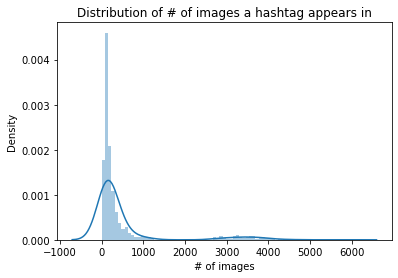

Total # of images to be added: 227068


In [10]:
tag_counts = Y_df.sum(axis=0).sort_values(ascending=True)
tag_counts.sort_values()

mean = tag_counts.mean()
std = tag_counts.std()
max_count = tag_counts.max()
add_count = {}

total = 0
i = 0
for tag, count in tag_counts.items():
    base = (max_count - count)//2 if count > mean+std else count
    num_to_add = int(base / (1+np.exp(-(count-mean)/std)))
    add_count[tag] = num_to_add
    tag_counts[tag] += num_to_add
    total += num_to_add
    i += 1

plt.title("Distribution of # of images a hashtag appears in")
sns.distplot(tag_counts, bins=75, axlabel="# of images")
plt.show()
add_count = pd.Series(add_count)
print(f"Total # of images to be added: {total}")

In [10]:
add_count.to_csv("../model/add_counts.csv", header=False)

Once we create `add_count` which contains the number of images to be added for each hashtag, we use `./src/download_images.py` to download images.